In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
sys.path.append('..')
# Import custom loss functions
from utils import angle_error_regression, load_and_pair_data3,load_and_pair_data


In [2]:
# model_path = r'C:\Study\colour-stander_Q-FOM-image-rotation-and-left-right-side-multi-head-network-main\models\multihead_model.hdf5'  # Ensure the path is consistent with the one used during model training and saving

# Set the path
# image_dir = r"C:\Users\13051\Desktop\RotationAngle\RotationAngle\DATASET\STANDARDIZED\cut_masks"
# csv_path = r"C:\Users\13051\Desktop\RotationAngle\RotationAngle\DATASET\dataset_image_rotation_data.csv"

# Set the path
model_path = r"C:\Study\colour-stander_Q-FOM-image-rotation-and-left-right-side-multi-head-network-main\models\multihead_model_standardized_color_RAW.hdf5"  # Ensure the path is consistent with the one used during model training and saving
image_dir = r"C:\Users\13051\Desktop\RotationAngle\RotationAngle\EXTRA\RAW\images"
csv_path = r"C:\Users\13051\Desktop\RotationAngle\RotationAngle\EXTRA\extra_image_rotation_data.csv"


In [3]:
# Load test data
images, angles, labels = load_and_pair_data3(image_dir, csv_path, target_size=(96, 128))

# Convert string labels to binary
labels = np.array(labels, dtype=str)
binary_labels = np.where(labels == 'Left', 0, 1)
one_hot_labels = np.eye(2)[binary_labels]  # Convert to one-hot encoding

# Split data into training and testing sets for both tasks
X_train, X_test = images, images
y_reg_train, y_reg_test = angles, angles
y_cls_train, y_cls_test = one_hot_labels, one_hot_labels


# Ensure data is in float32 format
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Expand dimensions for grayscale images
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Ensure the data shape is correct
print(f"Testing data shape: {X_test.shape}")
print(f"Testing regression labels shape: {y_reg_test.shape}")
print(f"Testing classification labels shape: {y_cls_test.shape}")


Testing data shape: (705, 128, 96, 3, 1)
Testing regression labels shape: (705,)
Testing classification labels shape: (705, 2)


In [4]:
# Load the trained model
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Trained model not found at {model_path}")
multihead_model = load_model(model_path, custom_objects={'angle_error_regression': angle_error_regression})

# Evaluate the model
loss, reg_loss, cls_loss, cls_accuracy = multihead_model.evaluate(
    X_test,
    {'regression_output': y_reg_test, 'classification_output': y_cls_test},
    verbose=1
)
print(f"\nTest Loss: {loss:.4f}")
print(f"Regression Loss: {reg_loss:.4f}")
print(f"Classification Loss: {cls_loss:.4f}")
print(f"Classification Accuracy: {cls_accuracy:.4f}")


23/23 [==============================] - 3s 17ms/step - loss: 6.0618 - regression_output_loss: 6.0323 - classification_output_loss: 0.0294 - classification_output_accuracy: 1.0000

Test Loss: 6.0618
Regression Loss: 6.0323
Classification Loss: 0.0294
Classification Accuracy: 1.0000


In [5]:
# Make predictions using the model
y_pred_reg, y_pred_cls = multihead_model.predict(X_test)

In [6]:
# Convert the one-hot encoded classification predictions to labels
y_pred_cls_labels = np.argmax(y_pred_cls, axis=1)
y_pred_cls_labels_str = np.where(y_pred_cls_labels == 0, 'Left', 'Right')

# Convert the one-hot encoded true classification values to labels
y_true_cls_labels = np.argmax(y_cls_test, axis=1)
y_true_cls_labels_str = np.where(y_true_cls_labels == 0, 'Left', 'Right')

# Create a dataFrame
data = {
    'true_angle': y_reg_test,  # True angles
    'predicted_angle': y_pred_reg.flatten(),  # Predicted angles
    'true_side': y_true_cls_labels_str,  # True sides
    'predicted_side': y_pred_cls_labels_str  # Predicted sides
}
df = pd.DataFrame(data)

# Save to an Excel file
output_excel_path = r"C:\Users\13051\Desktop\Test\y_test_y_predicted_results1.xlsx"
df.to_excel(output_excel_path, index=False)

print(f"Results saved to {output_excel_path}")

Results saved to C:\Users\13051\Desktop\Test\y_test_y_predicted_results1.xlsx


In [7]:
if 1 not in np.unique(np.argmax(y_cls_test, axis=1)):  
    print("No 'Right' labels in the test set. Adding manually...")
    y_true_cls_labels = np.append(y_true_cls_labels, 1)  
    y_pred_cls_labels = np.append(y_pred_cls_labels, 1)  
# Print unique values to check category completeness (for debugging purposes)
print("Unique values in y_true_cls_labels:", np.unique(y_true_cls_labels))
print("Unique values in y_pred_cls_labels:", np.unique(y_pred_cls_labels))
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true_cls_labels, y_pred_cls_labels, target_names=['Left', 'Right']))

# Confusion matrix
cm = confusion_matrix(y_true_cls_labels, y_pred_cls_labels)
print("\nConfusion Matrix:")
print(cm)


No 'Right' labels in the test set. Adding manually...
Unique values in y_true_cls_labels: [0 1]
Unique values in y_pred_cls_labels: [0 1]

Classification Report:
              precision    recall  f1-score   support

        Left       1.00      1.00      1.00       705
       Right       1.00      1.00      1.00         1

    accuracy                           1.00       706
   macro avg       1.00      1.00      1.00       706
weighted avg       1.00      1.00      1.00       706


Confusion Matrix:
[[705   0]
 [  0   1]]


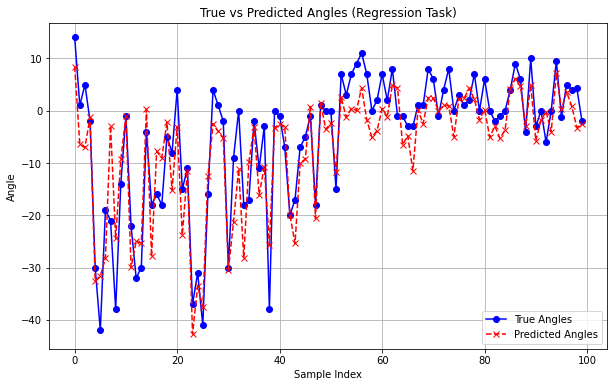

In [8]:
# Plot the comparison between predictions and true labels (regression task)
plt.figure(figsize=(10, 6))
plt.plot(y_reg_test[:100], label="True Angles", color='b', linestyle='-', marker='o')  # Display the first 50 samples
plt.plot(y_pred_reg[:100], label="Predicted Angles", color='r', linestyle='--', marker='x')
plt.title("True vs Predicted Angles (Regression Task)")
plt.xlabel("Sample Index")
plt.ylabel("Angle")
plt.legend()
plt.grid(True)
plt.show()


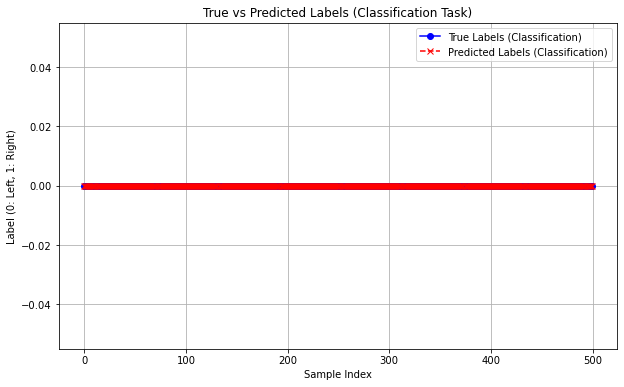

In [9]:
# Plot the comparison between predictions and true labels (classification task)
plt.figure(figsize=(10, 6))
plt.plot(y_true_cls_labels[:500], label="True Labels (Classification)", color='b', linestyle='-', marker='o')
plt.plot(y_pred_cls_labels[:500], label="Predicted Labels (Classification)", color='r', linestyle='--', marker='x')
plt.title("True vs Predicted Labels (Classification Task)")
plt.xlabel("Sample Index")
plt.ylabel("Label (0: Left, 1: Right)")
plt.legend()
plt.grid(True)
plt.show()


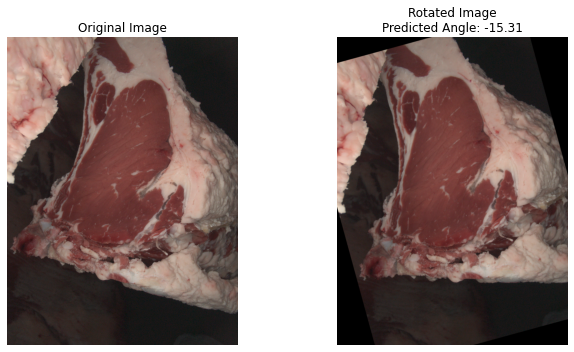

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to predict the angle and reverse rotate the image
def predict_and_rotate(model, image, target_size=(96, 128)):
    """
    Predict the angle using the model and reverse rotate the image
    
    Parameters:
        model: Loaded model
        image: Input image as a numpy array (RGB).
        target_size: Input image size required by the model, default is (96, 128)

    Returns:
        rotated_image: Reverse rotated image
        predicted_angle: Angle predicted by the model
    """
    # Resize the image
    resized_image = cv2.resize(image, target_size)

    # Add batch dimension and make prediction
    input_image = np.expand_dims(resized_image, axis=0)
    predicted_angle = float(model.predict(input_image)[0][0])  # Get the predicted angle as a float

    # Compute reverse rotation matrix
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, -predicted_angle, 1.0)

    # Reverse rotate the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

    return rotated_image, predicted_angle


# Load sample image
image_path = r"C:\Users\13051\Desktop\RotationAngle\RotationAngle\EXTRA\RAW\images\GRADE_N20210323-0003_D20230705_T115443_M4993_I993070311221_S14.png"
original_image = cv2.imread(image_path)
if original_image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

# Convert to grayscale image (adjust based on model requirements)
if original_image.shape[-1] == 3:  # If it is an RGB image
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
else:
    gray_image = original_image

# Call the prediction and rotation function
rotated_image, predicted_angle = predict_and_rotate(multihead_model, original_image)

# Display the original and rotated images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
plt.title(f"Rotated Image\nPredicted Angle: {predicted_angle:.2f}")
plt.axis("off")

plt.tight_layout()
plt.show()


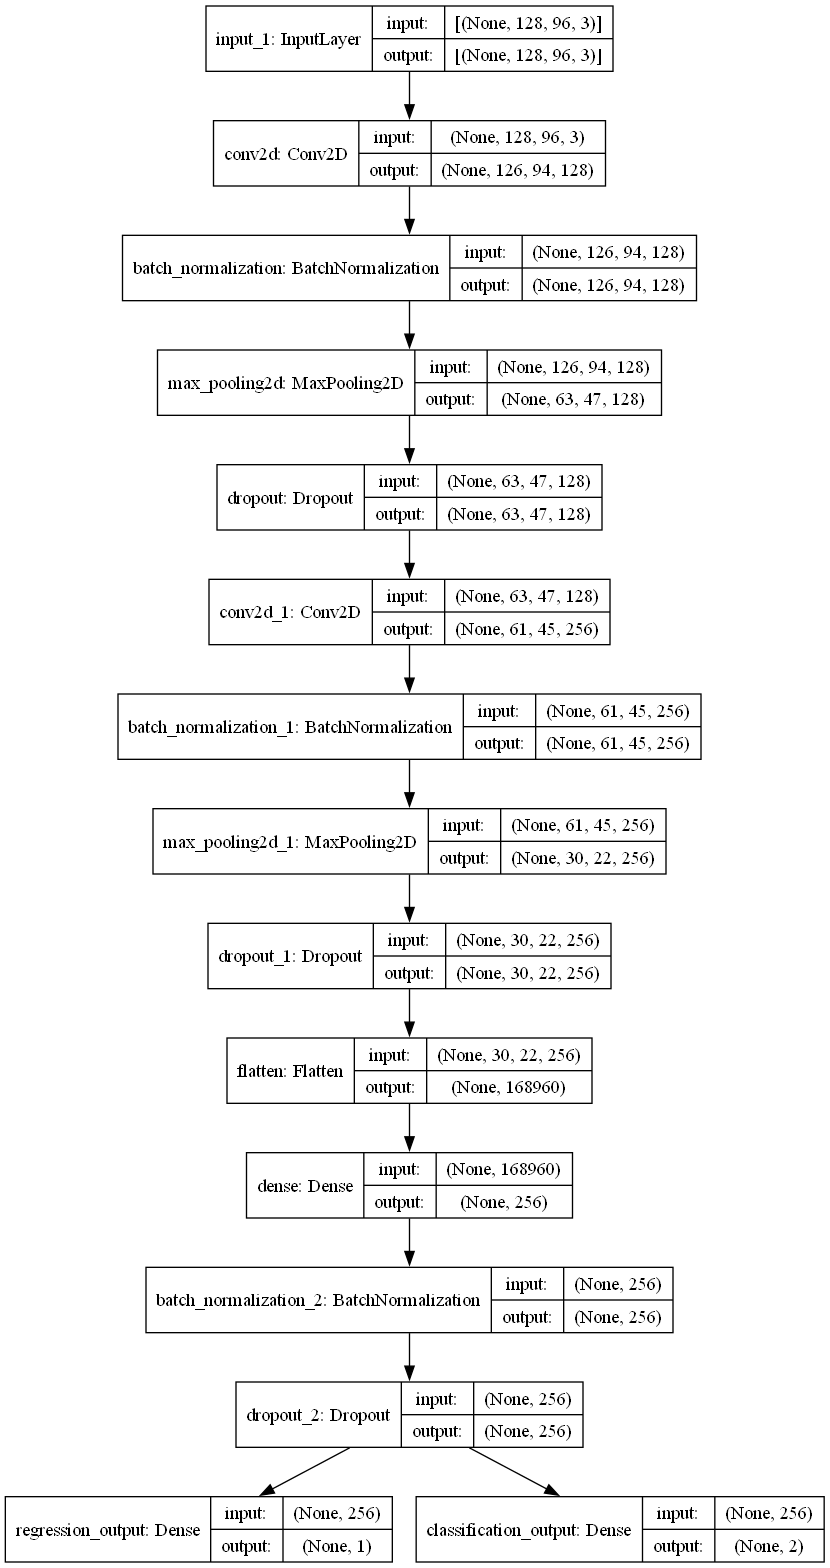

In [11]:
# Visualize the model
from tensorflow.keras.utils import plot_model
plot_model(
    multihead_model, 
    to_file=r'C:\Study\poster_figure\model_structure.png',  # Save path
    show_shapes=True,  # Display input/output shapes of layers
    show_layer_names=True  # Display layer names
)


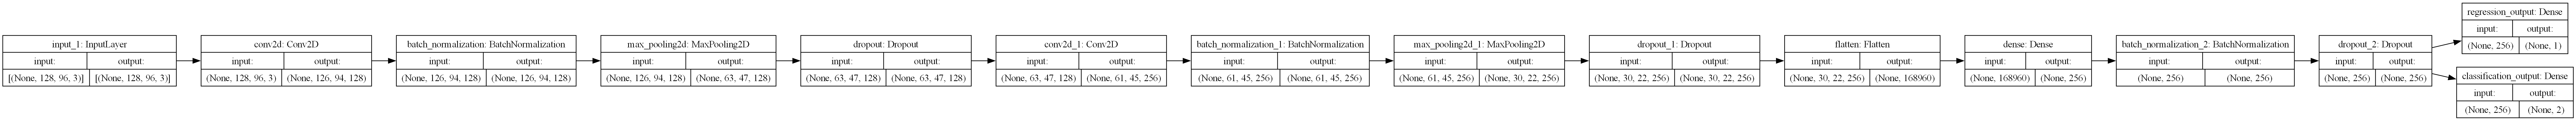

In [12]:
from tensorflow.keras.utils import plot_model

# Visualize the model with a horizontal layout and high resolution
plot_model(
    multihead_model,
    to_file=r'C:\Study\poster_figure\model_structure.png',  # Save as a horizontal high-resolution structure diagram
    show_shapes=True,  # Display input/output shapes
    show_layer_names=True,  # Display layer names
    rankdir='LR',  # Set layout direction to left-to-right
    dpi=200  # Set resolution, default is 96, increased to 200
)

# Display the generated model diagram
from IPython.display import Image
Image(filename='C:\Study\poster_figure\model_structure.png')
